# 1.0 Necessary setup of models
backend work that is needed before a demonstration can begin

## 1.1 Import of libraries and data

In [ ]:
# Import statements
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models
import matplotlib.pyplot as plt
import pandas as pd

# format confidences to be displayed in percent format
pd.set_option('float_format', '{:.1f}'.format)

torch.set_grad_enabled(False)
'''Imported'''

'Imported'

In [ ]:
# Mount drive to retrieve images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Retrieve test images
!unzip -q /content/drive/MyDrive/APS360_Project/Mush_test.zip -d /content/Mush_test

## 1.2 Setup of loader for test images

In [ ]:
# Create a loader for the images
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
mean = torch.FloatTensor(mean).view(3,1,1)
std = torch.FloatTensor(std).view(3,1,1)

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder('/content/Mush_test', transform=transform)
image_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

classes = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma',
           'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']

## 1.3 Import of Big Fungus model

In [ ]:
# Import the final model

# Define the FC layers
class ClassyMush(nn.Module):
    def __init__(self):
        super(ClassyMush, self).__init__()
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 9)
        #self.fc3 = nn.Linear(1024, 9)

    def forward(self, x):
        x = x.view(-1, 2048*1*1) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

BigFungus = ClassyMush()

# Download a pretrained ResNet-152 net model
ResNet = torchvision.models.resnet152(pretrained=True, progress=False)
modules = list(ResNet.children())[:-1] # delete the last fc layer.
ResNetCL = nn.Sequential(*modules)

# Import the weights
save_path = "/content/drive/MyDrive/APS360_Project/FinalModel/"
model_path = save_path + 'fc_states.pt'
res_net_path = save_path + 'ResNet_states.pt'
BigFungus.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
ResNetCL.load_state_dict(torch.load(res_net_path, map_location=torch.device('cpu')))

BigFungus.eval()
ResNetCL.eval()
'''Done'''

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


'Done'

## 1.4 Import of Fully-connected baseline

In [ ]:
# Fully connected model
class BasedANN(nn.Module):
    def __init__(self):
        super(BasedANN, self).__init__()
        self.fc1 = nn.Linear(3 * 240 * 240, 1024)
        self.fc2 = nn.Linear(1024, 9)

    def forward(self, x):
        x = x.view(-1, 3 * 240 * 240) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

FC_Baseline = BasedANN()

# Import the weights
save_path = "/content/drive/MyDrive/APS360_Project/ANNBaseline/"
model_path = save_path + 'bs512_lr0.001_epoch10'
FC_Baseline.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

FC_Baseline.eval()
'''Done'''

'Done'

## 1.5 Import of CNN baseline

In [ ]:
# Convolutional neural network model
class MushCNN(nn.Module):
    def __init__(self):
        super(MushCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 57 * 57, 1000)
        self.fc2 = nn.Linear(1000, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 57 * 57)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

CNN_Baseline = MushCNN()

# Import the weights
save_path = '/content/drive/MyDrive/APS360_Project/CNNBaseline/'
model_path = save_path + 'MushCNN_512_0.005_23'
CNN_Baseline.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

CNN_Baseline.eval()
'''Done'''

'Done'

# 2.0 Evaluation of new images

In this demonstration, one example test image will be selected at random from each genus. These images will then be used to evaluate the performance of each model.

## 2.1 Selection of 1 random test image from each genus

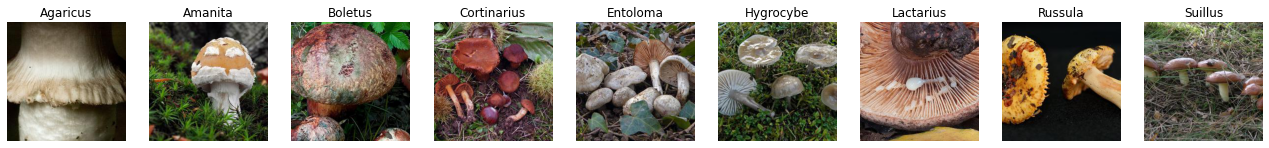

In [ ]:
# Image tensor
images = torch.tensor([])

# Choose an image from each class
for c in range(len(classes)):
  for img, label in image_loader:
    if c == label:
      images = torch.cat((images, img), 0)
      break

# Display the images
fig, plots = plt.subplots(1, len(classes), figsize=(2.5 * len(classes), 4))

for c in range(len(classes)):
  plots[c].axis('off')
  plots[c].title.set_text(classes[c])
  plots[c].imshow(transforms.functional.to_pil_image(images[c] * std + mean))

## 2.2 Model predictions

In [ ]:
# Calculate confidence on each image for each model
BigFungus_conf    = F.softmax(BigFungus(ResNetCL(images)), dim=1)
FC_Baseline_conf  = F.softmax(FC_Baseline(images), dim=1)
CNN_Baseline_conf = F.softmax(CNN_Baseline(images), dim=1)

# convert predictions to a table
raw_data = []
BigFungus_pred    = BigFungus_conf.max(1)[1]
FC_Baseline_pred  = FC_Baseline_conf.max(1)[1]
CNN_Baseline_pred = CNN_Baseline_conf.max(1)[1]
for c in range(len(classes)):
  raw_data.append([])
  raw_data[c].append(classes[BigFungus_pred[c].item()])     # Big Fungus
  raw_data[c].append(classes[FC_Baseline_pred[c].item()])   # Fully Connected
  raw_data[c].append(classes[CNN_Baseline_pred[c].item()])  # CNN

# use a pandas df to display the result
prediction_df = pd.DataFrame(raw_data, index=classes,
                             columns=['BigFungus', 'Fully Conn', 'Convolutional'])

prediction_df

,BigFungus,Fully Conn,Convolutional
Agaricus,Amanita,Boletus,Boletus
Amanita,Amanita,Amanita,Amanita
Boletus,Boletus,Russula,Boletus
Cortinarius,Cortinarius,Lactarius,Cortinarius
Entoloma,Entoloma,Lactarius,Lactarius
Hygrocybe,Hygrocybe,Russula,Amanita
Lactarius,Lactarius,Boletus,Russula
Russula,Cortinarius,Lactarius,Russula
Suillus,Suillus,Lactarius,Boletus


## 2.3 Model Confidence

In [ ]:
# df for BigFungus confidence for each prediciton
BigFungus_df = pd.DataFrame(BigFungus_conf.numpy() * 100, index=classes, columns=classes)
BigFungus_df

,Agaricus,Amanita,Boletus,Cortinarius,Entoloma,Hygrocybe,Lactarius,Russula,Suillus
Agaricus,0.0,67.9,1.0,0.9,0.1,0.0,0.2,29.8,0.0
Amanita,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Boletus,2.1,0.4,96.6,0.2,0.0,0.0,0.0,0.7,0.0
Cortinarius,0.0,0.0,0.0,98.6,0.0,0.0,0.3,0.1,1.0
Entoloma,13.5,0.0,0.0,31.1,35.6,0.0,18.8,0.9,0.0
Hygrocybe,0.1,0.5,0.0,1.0,6.1,88.8,3.4,0.2,0.0
Lactarius,21.1,0.0,0.0,0.1,0.0,0.0,72.5,6.3,0.0
Russula,1.1,22.8,0.0,46.7,0.0,0.0,6.3,22.6,0.5
Suillus,0.1,0.2,15.3,0.6,0.0,0.6,3.5,0.0,79.7


In [ ]:
# df for FC_Baseline confidence for each prediciton
FC_Baseline_df = pd.DataFrame(FC_Baseline_conf.numpy() * 100, index=classes, columns=classes)
FC_Baseline_df

,Agaricus,Amanita,Boletus,Cortinarius,Entoloma,Hygrocybe,Lactarius,Russula,Suillus
Agaricus,19.8,5.6,30.7,0.4,3.2,0.3,18.5,17.1,4.2
Amanita,1.6,38.8,3.7,4.2,2.6,2.0,34.8,6.9,5.3
Boletus,0.4,3.6,32.9,3.7,0.8,1.1,22.7,33.0,1.8
Cortinarius,0.6,0.3,26.7,12.0,0.1,3.8,49.2,4.5,2.8
Entoloma,4.5,10.4,4.9,16.6,2.6,0.9,34.9,21.9,3.3
Hygrocybe,3.0,6.8,1.3,7.4,29.2,0.7,19.0,30.6,2.0
Lactarius,14.7,5.0,27.8,14.0,6.2,3.5,13.2,13.4,2.2
Russula,0.0,0.3,0.1,2.4,0.1,0.8,55.0,6.9,34.3
Suillus,1.1,3.7,3.4,8.1,5.0,8.8,57.1,4.7,8.1


In [ ]:
# df for CNN_Baseline confidence for each prediciton
CNN_Baseline_df = pd.DataFrame(CNN_Baseline_conf.numpy() * 100, index=classes, columns=classes)
CNN_Baseline_df

,Agaricus,Amanita,Boletus,Cortinarius,Entoloma,Hygrocybe,Lactarius,Russula,Suillus
Agaricus,1.8,8.9,64.9,0.0,0.7,0.0,8.6,14.2,0.8
Amanita,2.4,91.5,0.1,0.7,0.3,0.0,3.3,1.5,0.2
Boletus,0.5,5.3,77.5,0.5,0.3,0.4,10.1,4.3,1.0
Cortinarius,0.6,1.3,12.8,38.2,0.6,13.3,22.5,5.6,5.3
Entoloma,22.2,20.3,1.0,7.9,9.9,0.0,34.5,3.9,0.2
Hygrocybe,18.5,50.1,8.3,4.9,6.6,0.2,3.2,8.3,0.1
Lactarius,16.0,2.9,12.3,18.5,9.8,0.4,18.6,20.0,1.5
Russula,4.3,5.3,6.3,2.9,4.1,4.8,22.0,31.7,18.5
Suillus,5.7,11.6,29.4,8.4,10.5,4.3,17.3,8.4,4.5


# 3.0 Let's have some fun with the model!

## I wonder how Big Fungus performs on an image like this

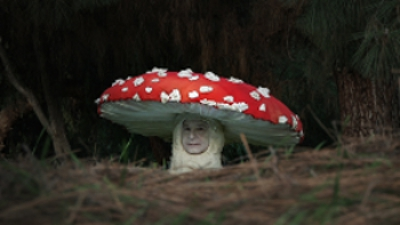

*Image credit: David Fenster*

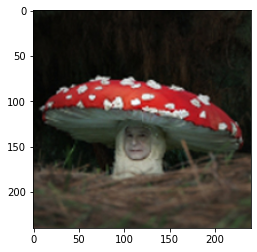

In [36]:
from PIL import ImageFile, Image

# Center crop the image to 240 x 240
IM_SIZE = 240

mush_man = Image.open('/content/drive/MyDrive/APS360_Project/MushroomMan.jpg')

width, height = mush_man.size
width -= width % 2
height -= height % 2
width_half = width // 2
height_half = height // 2

mush_man = mush_man.crop((width_half - height_half, 0, width_half + height_half, height))
mush_man = mush_man.resize((IM_SIZE, IM_SIZE))

plt.imshow(mush_man)

In [37]:
# Apply normalization to the image and feed it through the model
mush_man = transform(mush_man).unsqueeze(0)

prediciton = BigFungus(ResNetCL(mush_man)).max(1)[1] #argmax

print(classes[prediciton.item()])

Amanita
